In [1]:
import copy
from enum import Enum
import contextlib
import sys
from pathlib import Path
from typing import List

import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from tqdm.contrib import DummyTqdmFile

mi.set_variant("cuda_ad_rgb")

from mimt import *
# set_siggraph_font()

In [2]:
plt.style.use('ggplot')

# Expose repository main dir to mitsuba file resolver
# Avoids the need to provide absolute paths in the scene description
main_dir = Path().resolve().parent
mi.Thread.thread().file_resolver().append(str(main_dir)) 

#sess_seed   = np.random.randint(0, 2**30)
sess_seed   = 0
#sess_seed_g = np.random.randint(0, 2**30)
sess_seed_g = 1
print(f"session seeds are: sess_seed={sess_seed}; sess_seed_g={sess_seed_g}")


output_dir = (Path() / "out").resolve()
output_dir.mkdir(exist_ok=True, parents=True)

mi.Thread.thread().file_resolver().append(str(output_dir)) 

session seeds are: sess_seed=0; sess_seed_g=1


In [52]:
# This is a duplicate of the function in `utils`
def generate_shoebox(bsdf=None, meshpath = '.', **kwargs):
    tf = mi.ScalarTransform4f if mi.MI_VERSION.startswith("3.4") else mi.ScalarTransform4f()
    shoebox = {
        "type": "shapegroup",
        "back": {
            "type": "rectangle",
            "bsdf": { "type": "ref", "id": "back_bsdf" },
            "to_world": tf.translate([0., 0., -1.]).scale(1),
        },
        "front": {
            "type": "rectangle",
            "bsdf": { "type": "ref", "id": "front_bsdf" },
            "flip_normals": True,
            "to_world": tf.translate([0., 0., 1.]).scale(1),
        },
        "left": {
            "type": "rectangle",
            "bsdf": { "type": "ref", "id": "left_bsdf" },
            "to_world": tf.translate([-1., 0., 0.]).rotate(axis=[0., 1., 0.], angle=90),
        },
        "right": {
            "type": "rectangle",
            "bsdf": { "type": "ref", "id": "right_bsdf" },
            "to_world": tf.translate([1., 0., 0.]).rotate(axis=[0., -1., 0.], angle=90),
        },
        "top": {
            "type": "rectangle",
            "bsdf": { "type": "ref", "id": "top_bsdf" },
            "to_world": tf.translate([0., 1., 0.]).rotate(axis=[1., 0., 0.], angle=90),
        },
        "bottom": {
            "type": "rectangle",
            "bsdf": { "type": "ref", "id": "bottom_bsdf" },
            "to_world": tf.translate([0., -1., 0.]).rotate(axis=[-1., 0., 0.], angle=90),
        },
    }

    if bsdf is not None:
        for val in shoebox.values():
            if "bsdf" in val:
                val["bsdf"] = bsdf

    for face in list(shoebox.keys()):
        if face in kwargs and not kwargs[face]:
            shoebox.pop(face)

    return shoebox

def create_scene(seed: int, integrator: str, boxes: int, max_depth: int, samples: int, kappa: float = 0., t_bins: int = 200, t_max: float = 0.04, skip_direct: bool = True):
    absorption  = 0.1
    scattering  = 0.5

    tf          = mi.ScalarTransform4f()
    cam_pos     = np.array([-2.7, 0.79, -1.4]) # meter?

    emitter_pos = np.array([ 0., 0.99, 0.]) 

    box_dim = [3.,1.,2.]

    scene_dict = {
        "type": "scene",

        "integrator": {
            "type": integrator,
            "max_depth": max_depth,
        },

        "sensor": {
            "type": "perspective",
            "to_world": mi.ScalarTransform4f().look_at(
                origin = cam_pos,
                target = cam_pos+np.array([ 1.5, -0.5, 0.5]),
                up=[0, 1, 0],
            ),
            "fov":120,
            "film": {
                "type": "hdrfilm",
                "rfilter": { "type": "gaussian" },
                "width": 512,
                "height": 512,
                "sample_border": True,
            },
            "sampler": { "type": "independent", "sample_count": samples, },
        },
        
        'back_bsdf':   {'type': 'diffuse', 'reflectance': {'type': 'rgb', 'value': [.3, .3, .9]}},
        'front_bsdf':  {'type': 'diffuse', 'reflectance': {'type': 'rgb', 'value': [.9, .9, .3]}},
        'left_bsdf':   {'type': 'diffuse', 'reflectance': {'type': 'rgb', 'value': [.3, .9, .3]}},
        'right_bsdf':  {'type': 'diffuse', 'reflectance': {'type': 'rgb', 'value': [.3, .9, .9]}},
        'top_bsdf':    {'type': 'diffuse', 'reflectance': {'type': 'rgb', 'value': [.9, .3, .9]}},
        'bottom_bsdf': {'type': 'diffuse', 'reflectance': {'type': 'rgb', 'value': [.9, .3, .3]}},
        
        "emitter": {
            "type": "rectangle",
            "to_world": tf.translate([0., 0.9999, 0.]).rotate(axis=[1., 0., 0.], angle=90).scale(0.5),
            "emitter": { "type": "area", "radiance": { "type": "uniform", "value": 32 } },
        },

        'shoebox': generate_shoebox(),
        "main_box": {
            "type": "instance",
            "geometry": { "type": "ref", "id": "shoebox" },
            "to_world": tf.scale(box_dim),
        },
    }

    np.random.seed(seed)

    for i in range(boxes):
        axis = np.random.rand(3)-0.5
        axis /= np.linalg.norm(axis)
        angle = 360 * np.random.rand()
        scene_dict["cube"+str(i)] = {
            'type': 'ply',
            'filename': 'data/cube.ply',
            'to_world': mi.ScalarTransform4f().rotate([(np.random.rand()-0.5)*2, (np.random.rand()-0.5)*2, (np.random.rand()-0.5)*2], angle=angle).translate([(np.random.rand()-0.5)*2*box_dim[0]*0.2, (np.random.rand()-0.5)*2*box_dim[1]*0.2, (np.random.rand()-0.5)*2*box_dim[2]*0.2]).scale(0.04),
            "bsdf": {
                'type': 'blendbsdf',
                'weight': scattering,
                'bsdf_0': {'type': 'roughconductor',
                        'alpha': 0.02 ,
                        'specular_reflectance': 1. - absorption,
                        'distribution': 'beckmann'},
                'bsdf_1': { 'type': 'diffuse' , 'reflectance': 1. - absorption },
            },
        }

    return scene_dict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


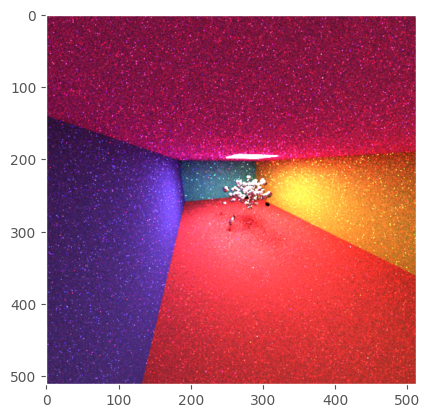

In [63]:
samples = 16
seed = 1337
boxes = 100
max_depth = 10

scene = mi.load_dict(create_scene(seed=seed, integrator="prb_threepoint", boxes=boxes, max_depth=max_depth, samples=samples))
img = mi.render(scene, seed=seed)
plt.grid(False)
plt.imshow(img)

In [64]:
# params = mi.traverse(scene)
# keys = lambda i: [f"cube{i}.bsdf.weight.value",
#   f"cube{i}.bsdf.bsdf_0.specular_reflectance.value",
#   # f"cube{i}.bsdf.bsdf_0.alpha.value",
#   # f"cube{i}.bsdf.bsdf_0.eta.value",
#   # f"cube{i}.bsdf.bsdf_0.k.value",
#   f"cube{i}.bsdf.bsdf_1.reflectance.value"]
# # display(params); throw
# bsdf_vals = []
# for i in range(boxes):
#     bsdf_vals.append([params[key] for key in keys(i)])
        
# def apply_transform(s):
#     for i in range(boxes):
#         for idx, key in enumerate(keys(i)):
#             params[key] = bsdf_vals[i][idx]+s[i][idx]
#     params.update()

# s = []
# for i in range(boxes):
#     s.append([mi.Float(0) for key in keys(i)])


In [65]:
params = mi.traverse(scene)

keys = lambda i: [f"cube{i}.vertex_positions"]

pos_vals = []
for i in range(boxes):
    pos_vals.append([mi.Point3f(dr.unravel(mi.Point3f,params[key])) for key in keys(i)])
        
def apply_transform(s):
    for i in range(boxes):
        for idx, key in enumerate(keys(i)):
            params[key] = dr.ravel(mi.Transform4f().translate(s[i][idx]) @ pos_vals[i][idx])
    params.update()

s = []
for i in range(boxes):
    s.append([mi.Point3f(0.) for key in keys(i)])

apply_transform(s)

In [66]:
from time import time
duration = []
for j in range(3):
    dr.enable_grad(s)
    dr.set_grad(s, mi.Point3f(0.))
    # dr.set_grad(s, mi.Float(0.))
        
    apply_transform(s)
    img = mi.render(scene, params=params, seed=seed)
    
    loss = dr.sum((img**2))
    start = time()
    dr.backward_from(loss)
    dr.eval()
    duration.append(time() - start)
print(np.median(duration))

6.11437463760376


In [67]:
dr.grad(s)

[[[[913.27, 120.068, 506.696]]],
 [[[-28267.7, -38472, -21582.9]]],
 [[[25411.4, -615.517, -2632.55]]],
 [[[-229776, -276934, -98207.4]]],
 [[[-5585.73, -6629.28, 4176.03]]],
 [[[-4169.82, 4141.18, 5002.44]]],
 [[[506.49, -1342.52, -1932.95]]],
 [[[2208.22, -81.8579, 1120.5]]],
 [[[94727.9, -120112, -30199]]],
 [[[1519.25, 2183.35, 1299.83]]],
 [[[17603.7, -13386.6, 12112.1]]],
 [[[116.511, 4199.81, -11552.9]]],
 [[[-17588.6, 11052.9, -5394.28]]],
 [[[-58484.2, -103832, -17951.2]]],
 [[[253.812, 1837.67, 1500.04]]],
 [[[9342, 1619.25, -3045.39]]],
 [[[41462.1, 17929.8, 28343.9]]],
 [[[4004.79, 8761.58, -31980.9]]],
 [[[-601438, -177366, -91529.5]]],
 [[[-5979.28, -546.338, 6694.36]]],
 [[[-741.196, 2684.74, -283.688]]],
 [[[-185097, -281984, 323723]]],
 [[[6432.58, 10729.5, -9517.09]]],
 [[[-5293.44, -11279.6, -1464.52]]],
 [[[-1832.33, 537.063, -305.305]]],
 [[[-2285.36, -800.425, -9.09521]]],
 [[[-149.034, 3754.49, 1214.33]]],
 [[[-5662.76, -27147.6, -10741.9]]],
 [[[-3172.17, 789.88

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.211903

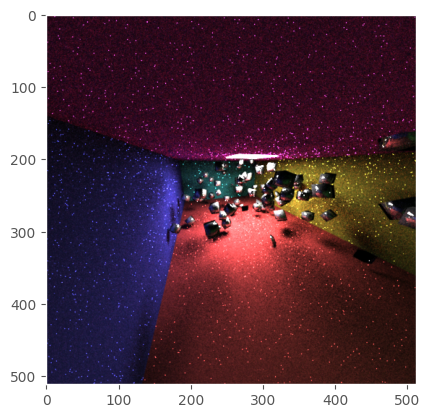

In [11]:
s = []
for i in range(boxes):
    s.append([mi.Point3f(0.) for key in keys(i)])
apply_transform(s)
img = mi.render(scene, params=params, seed=seed)
plt.grid(False)
plt.imshow(img)
loss = dr.mean((img))
loss